In [269]:
import math
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib.pylab import plt
import seaborn as sns

In [270]:
movies_df = pd.read_csv("movies_with_franchises.csv", index_col = 0)
games_df = pd.read_csv("clean_games_with_franchises.csv", index_col = 0)

D:\Programs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Naming convention to standardise the column names

In [271]:
games_df = games_df.drop("titleType", axis = 1)
games_df = games_df.rename(columns = {"rating": "age_rating", "startYear": "year", "primaryTitle": "title", "averageRating": "rating", "numVotes": "votes", "isAdult" : "is_adult"})
movies_df = movies_df.rename(columns={"startYear": "year", "primaryTitle": "title", "isAdult" : "is_adult", "runtimeMinutes": "runtime", "averageRating": "rating", "numVotes": "votes"})
movies_df = movies_df[["franchise_name", "franchise_id", "tconst", "title", "year", "is_adult", "runtime", "genres", "rating", "votes"]]

In [272]:
games_df.sample()

,franchise_name,franchise_id,tconst,title,year,is_adult,rating,votes,game_id,best_fit_ratio,genres,developers,platforms,publishers,age_rating
14259,Dragon Ball Z,3025-159,tt5565974,Dragon Ball Z: Dokkan Battle,2015,0,7.2,60.0,5894.0,98.181818,"['Fighting', 'Action']",NaN,"['iPhone', 'iPad', 'Android']",['Bandai Namco Entertainment'],NaN


In [273]:
movies_df.sample()

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes
88290,NaN,NaN,tt0194506,virou bagunça,1960,0,90,"Comedy,Musical",5.6,22.0


- Normalize movies and games 
- Calculate z-scores
- Add the following headings\
    &emsp;"Time until next movie"\
    &emsp;"Difference in rating"
    
    &emsp;"Number in Franchise"

Get number of movies/games in franchise

In [274]:
movies_df['franchise_count'] = movies_df['franchise_id'].map(movies_df['franchise_id'].value_counts())
games_df['franchise_count'] = games_df['franchise_id'].map(games_df['franchise_id'].value_counts())
movies_df.sample()

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,franchise_count
251756,NaN,NaN,tt4942328,veer baahubali,2005,0,\N,Action,4.0,13.0,NaN


Get an overview of how many franchises have x amount of movies / games

In [275]:
movies_df["franchise_id"].value_counts().value_counts().sort_index()

1      158
2      154
3      399
4      152
5       69
6       52
7       36
8       23
9       16
10      18
11      10
12      11
13       9
14       3
15       8
16       7
17       2
18       2
19       4
20       4
21       3
22       3
23       1
24       3
25       2
27       1
28       3
31       1
33       1
34       1
35       1
36       1
38       1
39       1
42       1
46       1
48       1
52       1
62       1
63       1
73       1
77       1
145      1
Name: franchise_id, dtype: int64

In [276]:
games_df["franchise_id"].value_counts().value_counts().sort_index()

1      489
2      427
3      328
4      199
5      129
6      123
7       63
8       47
9       35
10      26
11      23
12      22
13      11
14      18
15      14
16      11
17       6
18       7
19       9
20      10
21       8
22       5
23       7
24       1
25       2
26       1
27       3
28       3
29       2
30       1
31       3
33       1
34       3
35       5
36       2
37       4
38       1
40       1
41       1
45       1
46       1
48       1
49       2
50       1
56       2
58       1
60       1
61       1
79       2
80       1
82       1
84       1
88       1
106      1
121      1
172      1
195      1
216      1
Name: franchise_id, dtype: int64

Get total number of franchises:

In [277]:
movies_df.franchise_id.nunique()

1169

In [278]:
games_df.franchise_id.nunique()

2073

Remove any movies or games where the total franchise count after matching the series is less than 3

In [279]:
movies_df[["franchise_id", "franchise_name", "franchise_count"]] = movies_df[["franchise_id", "franchise_name", "franchise_count"]].apply(lambda x: np.nan if x["franchise_count"] < 3 else x, axis=1).sort_values("franchise_count")
games_df[["franchise_id", "franchise_name", "franchise_count"]] = games_df[["franchise_id", "franchise_name", "franchise_count"]].apply(lambda x: np.nan if x["franchise_count"] < 3 else x, axis=1).sort_values("franchise_count")

Get total number of franchises with more than 3:

In [280]:
movies_df.franchise_id.nunique()

857

In [281]:
games_df.franchise_id.nunique()

1157

Remove non-numerical years from data and convert to int

In [282]:
movies_df = movies_df[~(movies_df["year"] == "\\N")]
games_df = games_df[~(games_df["year"] == "\\N")]
movies_df["year"] = movies_df["year"].apply(lambda x: int(x))
games_df["year"] = games_df["year"].apply(lambda x: int(x))

Create additional columns for the datasets containing average rating for the franchises

In [283]:
#av_vote_year = movies_df.groupby(['franchise_id', 'year'])['rating'].mean().reset_index(drop=False)
#movies_df = movies_df.merge(av_vote_year[['franchise_id', 'year', 'rating']], on=['franchise_id', 'year'], how = "outer", suffixes=(None, '_franchise_average'))
#av_vote_year = games_df.groupby(['franchise_id', 'year'])['rating'].mean().reset_index(drop=False)
#games_df = games_df.merge(av_vote_year[['franchise_id', 'year', 'rating']], on=['franchise_id', 'year'], how = "outer", suffixes=(None, '_franchise_average'))


In [313]:
movies_df = movies_df.sort_values(["franchise_id", "year"])
movies_df['year_difference'] = movies_df.groupby(['franchise_id'])['year'].diff()

In [314]:
games_df.sort_values(["franchise_id", "year"])
games_df['year_difference'] = games_df.groupby(['franchise_id'])['year'].diff()

In [309]:
movies_df.sort_values(["franchise_id", "year"]).head(10)

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,franchise_count,year_difference
4813,The Aldrich Family,f0,tt0032123,what a life,1939,0,75,"Comedy,Drama",6.9,93.0,11.0,NaN
4814,The Aldrich Family,f0,tt0033834,life with henry,1940,0,80,"Comedy,Family,Music",6.0,49.0,11.0,1.0
4815,The Aldrich Family,f0,tt0033708,henry aldrich for president,1941,0,75,"Comedy,Family",6.6,146.0,11.0,1.0
4816,The Aldrich Family,f0,tt0034842,"henry aldrich, editor",1942,0,72,"Comedy,Drama,Family",6.4,150.0,11.0,1.0
4817,The Aldrich Family,f0,tt0034844,henry and dizzy,1942,0,71,"Comedy,Family",7.2,58.0,11.0,0.0
4818,The Aldrich Family,f0,tt0035985,henry aldrich swings it,1943,0,64,"Comedy,Family",8.3,110.0,11.0,1.0
4819,The Aldrich Family,f0,tt0035983,henry aldrich gets glamour,1943,0,72,"Adventure,Comedy,Family",6.4,130.0,11.0,0.0
4820,The Aldrich Family,f0,tt0035984,henry aldrich haunts a house,1943,0,73,"Adventure,Comedy,Family",6.3,151.0,11.0,0.0
4821,The Aldrich Family,f0,tt0036909,"henry aldrich, boy scout",1944,0,66,"Comedy,Family",6.5,129.0,11.0,1.0
4822,The Aldrich Family,f0,tt0036907,henry aldrich plays cupid,1944,0,65,"Comedy,Family",8.2,100.0,11.0,0.0


## Creating a modified dataset, containing merged years

Create a copy

In [284]:
grouped_movies_df = movies_df.copy(deep=True)

Convert genres to list

In [285]:
grouped_movies_df["genres"] = grouped_movies_df.genres.apply(lambda x : x.split(','))

Get total for each year, for each franchise

In [286]:
grouped_movies_df['year_franchise_movies_total'] = grouped_movies_df.groupby(["franchise_id", "year"])["year"].transform('count')

In [ ]:
Create average votes and ratings for each franchise

In [287]:
grouped_movies = grouped_movies_df.groupby(["franchise_id", "year"]).agg({"votes": "mean", "rating": "mean"}).reset_index()
merged_df = pd.merge(grouped_movies_df, grouped_movies, on=["franchise_id", "year"], suffixes=(None, '_average'))

In [288]:
# group by name and release year, aggregate the franchise_id lists
merged_df = merged_df.groupby(['franchise_id', 'year'], as_index=False).agg(({
    'franchise_name': 'first',
    'franchise_id': 'first',
    'tconst': ", ".join,
    'title': ", ".join,
    "year": 'first',
    "is_adult": "first",
    "runtime" : "first",
    "genres": lambda x: list(set([i for l in x for i in l])),
    "votes_average": "first", 
    "rating_average": "first", 
    "franchise_count" : "first",
    "year_franchise_movies_total": "first", 
    }))

In [289]:
merged_df['year_difference'] = merged_df.groupby(['franchise_id'])['year'].diff()

In [298]:
merged_df

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,year_franchise_movies_total,year_difference
0,The Aldrich Family,f0,tt0032123,what a life,1939,0,75,"[Comedy, Drama]",93.000000,6.90,11.0,1.0,NaN
1,The Aldrich Family,f0,tt0033834,life with henry,1940,0,80,"[Comedy, Music, Family]",49.000000,6.00,11.0,1.0,1.0
2,The Aldrich Family,f0,tt0033708,henry aldrich for president,1941,0,75,"[Comedy, Family]",146.000000,6.60,11.0,1.0,1.0
3,The Aldrich Family,f0,"tt0034842, tt0034844","henry aldrich, editor, henry and dizzy",1942,0,72,"[Family, Comedy, Drama]",104.000000,6.80,11.0,2.0,1.0
4,The Aldrich Family,f0,"tt0035985, tt0035983, tt0035984","henry aldrich swings it, henry aldrich gets gl...",1943,0,64,"[Comedy, Adventure, Family]",130.333333,7.00,11.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4073,Renato Castellani's Italian neorealism trilogy,f993,tt0040018,it's forever springtime,1950,0,92,"[Comedy, Drama]",99.000000,6.40,3.0,1.0,2.0
4074,Renato Castellani's Italian neorealism trilogy,f993,tt0044572,two cents worth of hope,1952,0,110,"[Comedy, Romance]",658.000000,7.00,3.0,1.0,2.0
4075,It's Alive,f994,"tt0071198, tt0071675","the bat people, it's alive",1974,0,93,"[Sci-Fi, Romance, Horror]",5449.500000,4.25,4.0,2.0,NaN
4076,It's Alive,f994,tt0077756,it lives again,1978,0,91,"[Sci-Fi, Horror]",2494.000000,5.20,4.0,1.0,4.0


<AxesSubplot:ylabel='Density'>

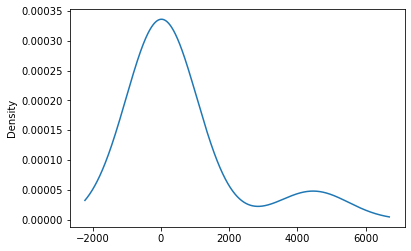

In [322]:
movies_df["year_difference"].describe().plot.kde()

In [316]:
games_df["year_difference"].describe()

count    8708.000000
mean        0.834864
std         8.618455
min       -50.000000
25%        -2.000000
50%         1.000000
75%         4.000000
max        42.000000
Name: year_difference, dtype: float64

In [310]:
merged_df["year_difference"].describe()

count    3221.000000
mean        4.241540
std         7.022946
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        83.000000
Name: year_difference, dtype: float64

## More code

In [36]:
movies_df = movies_df.sort_values(['franchise_id', 'year'])
movies_df['Year Gap'] = movies_df.groupby('franchise_id')['year'].diff()
movies_df['Rating_Difference'] = movies_df.groupby('franchise_id')['rating'].diff()
movies_df['Votes_Difference'] = movies_df.groupby('franchise_id')['votes'].diff()

In [41]:
#movies_df['AAAAHH'] = movies_df.groupby(['franchise_id','year'])['year'].diff()
movies_df['year_diff'] = movies_df.groupby(['franchise_id', 'year'])['year'].diff().reset_index(drop=True)

In [43]:
movies_df['year_difference'] = movies_df.groupby(['franchise_id', 'year'])['year'].diff()

# exclude same year differences
movies_df.loc[movies_df['year_difference'] == 0, 'year_difference'] = pd.NA

In [ ]:
grouped_movies = 

In [44]:
movies_df.head(20)

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,franchise_count,rating_franchise_average,Year Gap,Rating_Difference,Votes_Difference,AAAAHH,year_diff,year_difference
4822,The Aldrich Family,f0,tt0032123,what a life,1939,0,75,"Comedy,Drama",6.9,93.0,11.0,6.9,NaN,NaN,NaN,NaN,NaN,NaN
4823,The Aldrich Family,f0,tt0033834,life with henry,1940,0,80,"Comedy,Family,Music",6.0,49.0,11.0,6.0,1.0,-0.9,-44.0,NaN,NaN,NaN
4824,The Aldrich Family,f0,tt0033708,henry aldrich for president,1941,0,75,"Comedy,Family",6.6,146.0,11.0,6.6,1.0,0.6,97.0,NaN,NaN,NaN
4825,The Aldrich Family,f0,tt0034842,"henry aldrich, editor",1942,0,72,"Comedy,Drama,Family",6.4,150.0,11.0,6.8,1.0,-0.2,4.0,NaN,NaN,NaN
4826,The Aldrich Family,f0,tt0034844,henry and dizzy,1942,0,71,"Comedy,Family",7.2,58.0,11.0,6.8,0.0,0.8,-92.0,0.0,NaN,<NA>
4827,The Aldrich Family,f0,tt0035985,henry aldrich swings it,1943,0,64,"Comedy,Family",8.3,110.0,11.0,7.0,1.0,1.1,52.0,NaN,NaN,NaN
4828,The Aldrich Family,f0,tt0035983,henry aldrich gets glamour,1943,0,72,"Adventure,Comedy,Family",6.4,130.0,11.0,7.0,0.0,-1.9,20.0,0.0,NaN,<NA>
4829,The Aldrich Family,f0,tt0035984,henry aldrich haunts a house,1943,0,73,"Adventure,Comedy,Family",6.3,151.0,11.0,7.0,0.0,-0.1,21.0,0.0,NaN,<NA>
4830,The Aldrich Family,f0,tt0036909,"henry aldrich, boy scout",1944,0,66,"Comedy,Family",6.5,129.0,11.0,7.7,1.0,0.2,-22.0,NaN,NaN,NaN
4831,The Aldrich Family,f0,tt0036907,henry aldrich plays cupid,1944,0,65,"Comedy,Family",8.2,100.0,11.0,7.7,0.0,1.7,-29.0,0.0,NaN,<NA>


In [ ]:
movies_df = movies_df.sort_values(['franchise_id', 'startYear'])
movies_df['Rating_Difference'] = movies_df.groupby('franchise_id')['averageRating'].diff()

In [ ]:
movies_df = movies_df.sort_values(['franchise_id', 'startYear'])
movies_df['Votes_Difference'] = movies_df.groupby('franchise_id')['numVotes'].diff()

In [ ]:
movies_df['franchise_position'] = movies_df.groupby("franchise_id")["startYear"].rank(method="first")

In [ ]:
movies_df3

In [ ]:
movies_df.groupby(['franchise_id', 'startYear']).size()

In [ ]:
movies_df

In [ ]:
movies_df.head(50)

In [ ]:
movies_df["Year Gap"].value_counts().plot()

# Notes
Using value_counts we discover 25% of our movies for the franchises are released in the same year. So we have to either get an average per year (in this case, we are looking at fatique over years as opposed to number of movies)

In [ ]:
movies_df[movies_df["franchise_id"] == "f1"].sort_values("startYear")

In [ ]:
cols = ["tconst", "averageRating", "numVotes", "startYear"]
#new_cols = ["tconst", "rating", "votes", "year"]

games_scores = games_df[cols]

movies_scores = movies_df[cols]

In [ ]:
%matplotlib inline

sns.set_context("talk", font_scale=.9)   
sns.set_context('talk')

fig_width, fig_height = 4, 3

In [ ]:
fig, ax = plt.subplots(figsize=(fig_width*3, fig_height*2))

interval = 0.01
((movies_scores['averageRating']/10)).hist(
    bins=25, ax=ax, grid=False, color="red", density=True, alpha=.4)
((games_scores['averageRating']/10)).hist(
    bins=25, ax=ax, grid=False, color="blue", density=True, alpha=.4)


ax.set_ylim(0, 5)
ax.set_xlim(0, 1)

ax.legend(['Movies', 'Games'], ncol=2, loc='upper left')

mean_movie_rating = (movies_scores['averageRating']/10).mean()
mean_game_rating = (games_scores['averageRating']/10).mean()

ax.axvline(mean_movie_rating, color="red")
ax.axvline(mean_game_rating, color="blue")

ax.text(mean_movie_rating, 6, '[1]', ha='center',color="red", backgroundcolor='w', fontsize=14)

ax.text(mean_game_rating, 6, '[2]', ha='center',color="blue", backgroundcolor='w', fontsize=14)


ax.text(
    0, 2,
    '''
    [1] Mean Movie Rating (All Movies, |)
    
    [2] Mean Game Rating (All Games, |)
    ''',
    fontsize=14
)

ax.set_xlabel('Movie/Game Rating (Normed)')
ax.set_ylabel('Relative Number of Movies/Games')

ax.set_title('{:,} Movies, {:,} Games'.format(len(movies_scores), len(games_scores)))

fig.tight_layout()

#fig.savefig('../../graphs/2400_fig_1_normed_rating_distributions.png', format='png', dpi=300)

In [ ]:
movies_df['averageRating'].agg(['mean', 'std'])

In [ ]:
movies_df['averageRating']

In [ ]:
(movies_df['averageRating']-movies_df['averageRating'].mean())/movies_df['averageRating'].std()

In [ ]:
stats.zscore(movies_df['averageRating'])

In [ ]:
stats.zscore(movies_df['averageRating']).mean()

In [ ]:
movies_df['z_rating_for_movie'] = stats.zscore(movies_df['averageRating'])

games_df['z_rating_for_game'] = stats.zscore(games_df['averageRating'])

fig, ax = plt.subplots(figsize=(fig_width*3, fig_height*2))


((movies_df['z_rating_for_movie'])).hist(
    bins=50, ax=ax, grid=False, color="red", density=True, alpha=.4)
((games_df['z_rating_for_game'])).hist(
    bins=50, ax=ax, grid=False, color="blue", density=True, alpha=.4)


ax.set_xlim(-5, 5)

ax.legend(['Movies', 'Games'], ncol=2, loc='upper left')

ax.axvline((movies_df['z_rating_for_movie']).mean(), lw=2, c="red")
ax.axvline((games_df['z_rating_for_game']).mean(), lw=2, c="blue")


ax.set_xlabel('Movie/Games Rating (Z-Scores)')
ax.set_ylabel('Relative Number of Movies/Games')
ax.set_title('{:,} Movies, {:,} Games'.format(len(movies_df), len(games_df)))

fig.tight_layout()

#fig.savefig('../../graphs/2400_fig_2_z_rating_distributions.png', format='png', dpi=300)

In [52]:
movies_df.count()

franchise_name              7481
franchise_id                7481
tconst                      7481
title                       7481
year                        7481
is_adult                    7481
runtime                     7481
genres                      7481
rating                      7481
votes                       7481
franchise_count             7481
rating_franchise_average    7481
Year Gap                    6569
Rating_Difference           6569
Votes_Difference            6569
AAAAHH                      1630
year_diff                   1630
year_difference                0
dtype: int64

In [89]:
sample_df = movies_df.sample(10000)
grouped_df = sample_df.groupby('franchise_id').apply(sample_func)

In [91]:
grouped_df

franchise_id           
f1            tt0071479    1
              tt0077517    2
f102          tt0040432    1
f103          tt0121864    1
f1041         tt0077737    1
                          ..
f97           tt0235005    1
f970          tt9732250    1
f977          tt2386490    1
f98           tt0039210    1
f987          tt0369060    1
Length: 279, dtype: int64

In [ ]:
franchise_df = grouped_df[grouped_df['franchise_id'] == 'f1334']

In [88]:
def sample_func(sub_df):
    
    movies_in_order = sub_df.sort_values('year')['tconst']
    return pd.Series({movie: k+1 for k, movie in enumerate(movies_in_order)})

In [ ]:
sample_func(franchise_df)

In [ ]:
l = ['a','b','c']
for k,i in enumerate(l):
    print(k,i)
    print(i,  '-->',  k+1)

In [ ]:
franchise_df.sort_values('startYear')['startYear']

In [ ]:
franchise_df.set_index('tconst').sort_values('startYear')['startYear'].map(int).diff()